<img src="bmi_banner.jpg" width ="95%" />

# EEG Signal Processing Clasification Notebook 


## About This Notebook

<img src="brain_waves.png" width ="40%" style="float: left;" />

<i>The project aims to process data from a low-cost EEG circuit to later classify brainwave patterns in order to create a Machine Learning model for use in a Brain-Computer Interface.

The Notebook is divide into:</i>

<blockquote> 
    
- Data acquisition from wav files
    
- Cutting the data borders 
- Passing a slider window
- Stacking epochs from the two classes 
- Preprocessing epochs
- Feature extraction
- Feature Selection
- Classification
</blockquote>

# Data acquisition from wav files
***
- Part I - *The first thing we have done was import some important libraries*

In [24]:
%%time
import soundfile as sf
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import pywt
import mpld3
import warnings
from scipy import signal
from scipy.signal import butter, lfilter, firwin
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from collections import defaultdict
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from entropy.entropy import *
warnings.filterwarnings('ignore')
# %matplotlib inline
# mpld3.enable_notebook()

Wall time: 0 ns


- Part II - *Opening WAV files and storing the data in some variable*

In [25]:
# LeftHand_RED_15Hz data
CloseEyes_1, fs1 = sf.read('CloseEyes\Oz1_Oz2_CloseEyes_1.wav')
CloseEyes_2, fs2 = sf.read('CloseEyes\Oz1_Oz2_CloseEyes_2.wav')
CloseEyes_3, fs3 = sf.read('CloseEyes\Oz1_Oz2_CloseEyes_3.wav')

# RightHand_WHITE_20Hz data
VEP_RED_10Hz_1, fs1 = sf.read('VEP_RED_10Hz\Oz1_Oz2_VEP_RED_10Hz_1.wav')
VEP_RED_10Hz_2, fs2 = sf.read('VEP_RED_10Hz\Oz1_Oz2_VEP_RED_10Hz_2.wav')
VEP_RED_10Hz_3, fs3 = sf.read('VEP_RED_10Hz\Oz1_Oz2_VEP_RED_10Hz_3.wav')


In [26]:
print('Size of  CloseEyes_1 data imported: ', CloseEyes_1.size)
print('Size of  CloseEyes_2 data imported: ', CloseEyes_2.size)
print('Size of  CloseEyes_3 data imported: ', CloseEyes_3.size)

print('Size of  VEP_RED_10Hz_1 data imported:', VEP_RED_10Hz_1.size)
print('Size of  VEP_RED_10Hz_2 data imported:', VEP_RED_10Hz_2.size)
print('Size of  VEP_RED_10Hz_3 data imported: ', VEP_RED_10Hz_3.size)

Size of  CloseEyes_1 data imported:  633432
Size of  CloseEyes_2 data imported:  697341
Size of  CloseEyes_3 data imported:  1169170
Size of  VEP_RED_10Hz_1 data imported: 767538
Size of  VEP_RED_10Hz_2 data imported: 734527
Size of  VEP_RED_10Hz_3 data imported:  809720


# Preprocessing epochs

### Cutting the data borders
***
- Part I - *Here we cut the data border because it is necessary to let the array with the size multiple of the frequence sample*

In [27]:
def cutSignal(row, fs1):
    m1 = ((row.size % fs1) // 2) if (((row.size % fs1) % 2) == 0) else (((row.size % fs1) // 2) + 1)
    row = row[((row.size % fs1) // 2):][:-m1]
    return row

In [28]:
# Cutting the edges of the data
CloseEyes_1 = cutSignal(CloseEyes_1,fs1)
CloseEyes_2 = cutSignal(CloseEyes_2,fs1)
CloseEyes_3 = cutSignal(CloseEyes_3,fs1)

VEP_RED_10Hz_1 = cutSignal(VEP_RED_10Hz_1,fs1)
VEP_RED_10Hz_2 = cutSignal(VEP_RED_10Hz_2,fs1)
VEP_RED_10Hz_3 = cutSignal(VEP_RED_10Hz_3,fs1)


print('Size of  CloseEyes_1 data imported: ', CloseEyes_1.size)
print('Size of  CloseEyes_2 data imported: ', CloseEyes_2.size)
print('Size of  CloseEyes_3 data imported: ', CloseEyes_3.size)

print('Size of  VEP_RED_10Hz_1 data imported:', VEP_RED_10Hz_1.size)
print('Size of  VEP_RED_10Hz_2 data imported:', VEP_RED_10Hz_2.size)
print('Size of  VEP_RED_10Hz_3 data imported: ', VEP_RED_10Hz_3.size)

Size of  CloseEyes_1 data imported:  630000
Size of  CloseEyes_2 data imported:  690000
Size of  CloseEyes_3 data imported:  1160000
Size of  VEP_RED_10Hz_1 data imported: 760000
Size of  VEP_RED_10Hz_2 data imported: 730000
Size of  VEP_RED_10Hz_3 data imported:  800000


Here we are gonna downsampling the data to 200 samples per second

In [29]:
def downsampling(arrays1, new_fs):
    data = []
    for arrays in arrays1:
        time = len(arrays) / fs1
        new_len = int(new_fs * time)
        data.append(signal.resample(arrays, new_len))
    return data
###############################################################

arrays1 = [CloseEyes_1, CloseEyes_2, CloseEyes_3]
arrays2 = [VEP_RED_10Hz_1, VEP_RED_10Hz_2, VEP_RED_10Hz_3]


data1 = downsampling(arrays1, 200)
data2 = downsampling(arrays2, 200)

Ploting the same data smapled and downsampled

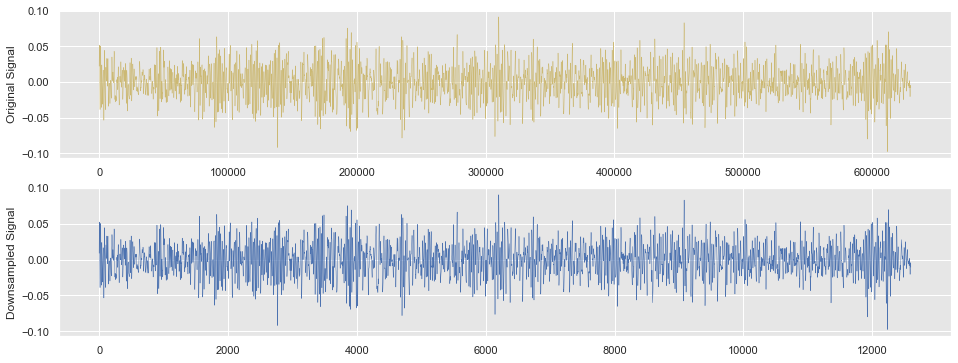

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(16,6))
axs[0].plot(CloseEyes_1, 'y', linewidth=0.5)
axs[0].set_ylabel('Original Signal')
axs[0].grid(True)

axs[1].plot(data1[0], 'b', linewidth=0.5)
axs[1].grid(True)
axs[1].set_ylabel('Downsampled Signal')
plt.show()

# Passing a slider window
***
- Part I - *In order to not lose information it is used sliding window technique with 2.5% of overlapping in relation to the time-window size*

<img src="window.png" alt="window" style="width: 50%;float:left; margin-right:60px"/>

<i>For each window that we extract, we create a epoch that is stored in an matrix that future will be used as a row of EEG in which represents one state we want classify</i>

<img src="lineEEG.jpg" alt="window" style="width: 30%;float:left; margin-right:60px"/>

In [31]:
def creat_matrix(row):
    vec1 = []
    for data1 in row:
        _wind = 0
        wind_ = 200
        while (len(data1) >= wind_):
            aux_LH = data1 [_wind:wind_]
            vec1.append(aux_LH)
            _wind += 5
            wind_ += 5
    classs = np.array(vec1) 
    return classs
##############################################

class1 = creat_matrix(data1)      
class2 = creat_matrix(data2)

print(class1.shape)
print(class2.shape)

(9803, 200)
(9043, 200)


# Stacking epochs from the two classes
***
- Part I - *In this brief part we stack row of EEG from either open eyes and closed eyes classes*

In [32]:
signals = np.vstack((class1,class2))

- Part II - <i> Here we are creating labels to classify the epochs(rows of EEG) into two classes that are represented as "1"s or "0"s</i>

In [33]:
label = []
a = np.full((len(class1)), 0)
b = np.full((len(class2)), 1)
label.extend(a)
label.extend(b)

- Part I - *First, we normalize the data to guarantee that there is no a huge variancy on the feature weights.*
   
  <i> (The DataFrame is created to show some statistics about the data)</i>

In [34]:
# Normalizing and transposing the matrix to analise on the pandas DataFrame
# signals_normalized = preprocessing.scale(signals)
scaled_signals = np.interp(signals, (-0.1, 0.1), (-1, +1))
df_stack = pd.DataFrame(np.transpose(scaled_signals))
df_stack.describe()

,0,1,2,3,4,5,6,7,8,9,...,18836,18837,18838,18839,18840,18841,18842,18843,18844,18845
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.001654,-0.001789,-0.007501,0.002230,0.007408,-0.002659,-0.003821,0.013800,0.022938,0.016024,...,-0.011390,-0.012807,-0.016377,-0.021341,-0.023760,-0.023031,-0.021081,-0.020886,-0.024442,-0.022707
std,0.240607,0.234929,0.229872,0.226178,0.223623,0.212974,0.210861,0.213997,0.217846,0.217677,...,0.129280,0.130610,0.130331,0.131304,0.134166,0.133852,0.134678,0.134711,0.134053,0.134712
min,-0.535208,-0.535208,-0.535208,-0.535208,-0.535208,-0.535208,-0.535208,-0.535208,-0.535208,-0.535208,...,-0.335330,-0.335330,-0.335330,-0.335330,-0.335330,-0.335330,-0.335330,-0.335330,-0.335330,-0.335330
25%,-0.192874,-0.192874,-0.192874,-0.173066,-0.167499,-0.167499,-0.167499,-0.139478,-0.136045,-0.139478,...,-0.097664,-0.104508,-0.108152,-0.118934,-0.124329,-0.120791,-0.120791,-0.120791,-0.120791,-0.120791
50%,-0.009066,-0.009066,-0.009066,0.005970,0.017462,0.014476,0.014476,0.022262,0.031532,0.020474,...,0.002468,0.002468,-0.001683,-0.005345,-0.005345,-0.005345,-0.002073,-0.001989,-0.007775,-0.005030
75%,0.176433,0.176433,0.169112,0.169112,0.169112,0.156234,0.149661,0.167675,0.179504,0.167675,...,0.081545,0.081545,0.079094,0.075700,0.075700,0.075700,0.079094,0.079094,0.072676,0.075700
max,0.525544,0.506785,0.506785,0.506785,0.506785,0.446429,0.446429,0.446429,0.446429,0.446429,...,0.329652,0.329652,0.329652,0.329652,0.329652,0.329652,0.329652,0.329652,0.329652,0.329652


After have been scaled the data, we are gonna high pass the rows of EEG

In [35]:
def get_fft(signal, fs):
    # Number of sample points
    n = len(signal)
    # sample spacing
    t = 1.0 / fs
    x = np.linspace(0.0, n * t, n)
    yf = fft(signal)
    signal_fft = 2.0 / n * np.abs(yf[0:n // 2])
    xf = np.linspace(0.0, 1.0 / (2.0 * t), n // 2)
    return xf, signal_fft

def get_high_pass_IIR(sig, fc, fs, order=10):
    b, a = butter(order, fc, 'hp', fs=fs)
#     filtered = sosfilt(sos, sig)
    filtered = signal.filtfilt(b, a, sig)
    return filtered

def get_high_pass_FIR(sig, fc, fs, order=11):
    nyq_rate = fs / 2.0
    f1 = fc / nyq_rate
    b = firwin(order, f1, pass_zero='highpass')
    filtered = lfilter(b, 1, sig)
    return filtered

In [36]:
filtered_signal = []
for row in scaled_signals:
    row = get_high_pass_IIR(row, 2, 200, order=5)
    filtered_signal.append(row)

#  Feature Extraction
***

# 1º Method 

#### Creating FFT Matrix

In [37]:
aux_fft =[]

for row in filtered_signal:
#     ft = scipy.fftpack.fft(row)
#     fft_row = 2.0/len(row) * np.abs(ft[:len(row)//4])
    f, pxx_den = welch(row, 200)
    aux_fft.append(pxx_den[:50])
    
##---     
ffts = np.array(aux_fft)
np.shape(ffts)

(18846, 50)

Calculing the the mean of frequencies that appear in each class

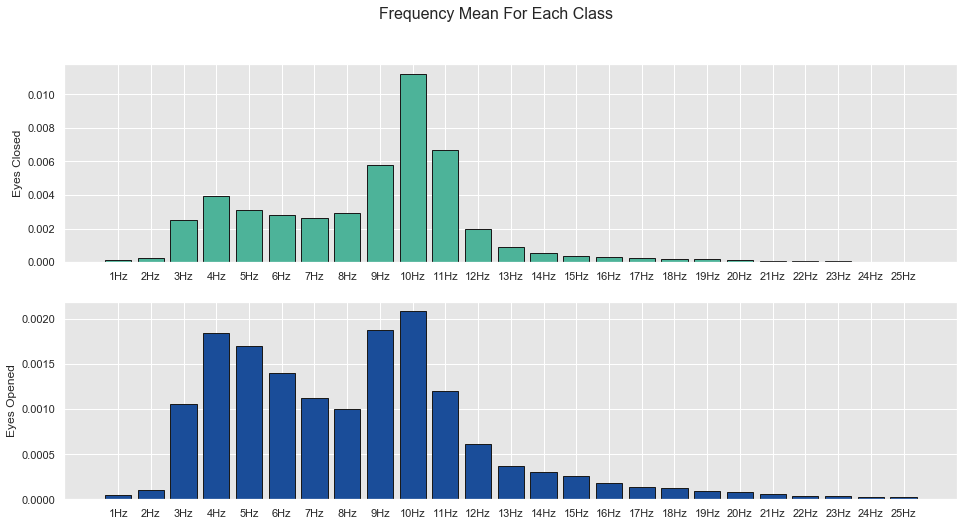

In [38]:
cols_fft = [str(i) + 'Hz' for i in range(1,51)]


df_CE_fft = pd.DataFrame(data=ffts[:len(class1)],columns=cols_fft)
df_OE_fft = pd.DataFrame(data=ffts[len(class1):],columns=cols_fft)

CE_fftMean = [df_CE_fft[clms].mean() for clms in cols_fft]
OE_fftMean = [df_OE_fft[clms].mean() for clms in cols_fft]



fig, ax = plt.subplots(2,1,figsize=(16,8))
fig.suptitle('Frequency Mean For Each Class', fontsize=16)
# ax[0].title.set_text('Frequency features from opened eyes')
ax[0].bar(cols_fft[:25],CE_fftMean[:25],edgecolor='k',color=(0.3, 0.7, 0.6))
ax[0].set_ylabel('Eyes Closed')
ax[0].grid(True)
# ax[1].title.set_text('Frequency features from closed eyes')
ax[1].bar(cols_fft[:25],OE_fftMean[:25],edgecolor='k',color=(0.1, 0.3, 0.6))
ax[1].set_ylabel('Eyes Opened')
ax[1].grid(True)

plt.show()

When the eyes are closed, it is possible to notice that alpha activity (8 to 12 Hz) has become predominant, increasing the amplitude of the wave.

# 2º Method 

#### Frequency Domain Features

In [39]:
# Features copied from Python Audio Analysis Library
# https://github.com/tyiannak/pyAudioAnalysis/blob/master/pyAudioAnalysis/audioFeatureExtraction.py

eps = 0.00000001
def stSpectralCentroidAndSpread(X, fs):
    """Computes spectral centroid of frame (given abs(FFT))"""
    ind = (np.arange(1, len(X) + 1)) * (fs/(2.0 * len(X)))

    Xt = X.copy()
    Xt = Xt / Xt.max()
    NUM = np.sum(ind * Xt)
    DEN = np.sum(Xt) + eps

    # Centroid:
    C = (NUM / DEN)

    # Spread:
    S = np.sqrt(np.sum(((ind - C) ** 2) * Xt) / DEN)

    # Normalize:
    C = C / (fs / 2.0)
    S = S / (fs / 2.0)

    return (C, S)

def stSpectralEntropy(X, n_short_blocks=10):
    """Computes the spectral entropy"""
    L = len(X)   # number of frame samples
    Eol = np.sum(X ** 2)   # total spectral energy

    sub_win_len = int(np.floor(L / n_short_blocks))  # length of sub-frame
    if L != sub_win_len * n_short_blocks:
        X = X[0:sub_win_len * n_short_blocks]

    # define sub-frames (using matrix reshape)
    sub_wins = X.reshape(sub_win_len, n_short_blocks, order='F').copy()
    # compute spectral sub-energies
    s = np.sum(sub_wins ** 2, axis=0) / (Eol + eps)
    # compute spectral entropy
    En = -np.sum(s*np.log2(s + eps))

    return En

def stSpectralRollOff(X, c, fs):
    """Computes spectral roll-off"""
    totalEnergy = np.sum(X ** 2)
    fftLength = len(X)
    Thres = c*totalEnergy
    # Ffind the spectral rolloff as the frequency position 
    # where the respective spectral energy is equal to c*totalEnergy
    CumSum = np.cumsum(X ** 2) + eps
    [a, ] = np.nonzero(CumSum > Thres)
    if len(a) > 0:
        mC = np.float64(a[0]) / (float(fftLength))
    else:
        mC = 0.0
    return (mC)


def getpeaks(x):
    data_max = np.amax(x)
    data_index, = np.where(x == np.amax(x))
    return data_max, int(data_index) + 1


def freq_features(row):
    fs = 200
    c, S = stSpectralCentroidAndSpread(row, fs)
    En = stSpectralEntropy(row, n_short_blocks=10)
    mC = stSpectralRollOff(row, c, fs)
    p, i = getpeaks(row)
    return c, S, En, mC, p ,i


Extracting Features

In [40]:
aux_fft_features = []

for row in ffts:
    aux = freq_features(row)
    aux_fft_features.append(aux)
    
fft_features = np.array(aux_fft_features)

Putting the results of the Features Extraction into a Dataframe and dividing x and y arrays 

In [41]:
freqFeatures_names = ['Centroid', 'Spread', 'Entropy', 'RollOff','peak', 'Frequency']
df_Ffft_x = pd.DataFrame(fft_features,columns=freqFeatures_names)
df_Ffft_y = pd.DataFrame(label)
df_Ffft = df_Ffft_x.copy()
df_Ffft.insert(6, "Label", 0) 
df_Ffft["Label"] = label

Here you can see the corelation matrix that show the corelation among the features and the target

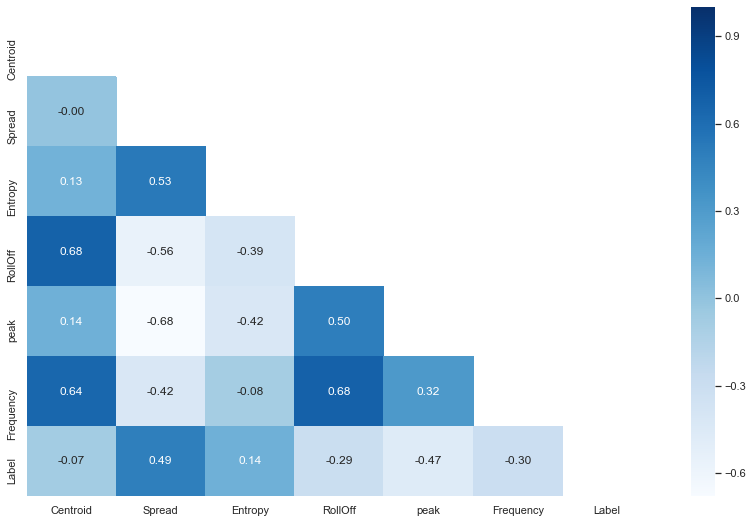

In [42]:
from string import ascii_letters

sns.set(style="white")
# Compute the correlation matrix
corr = df_Ffft.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 9))

# Generate a custom diverging colormap
cmap = 'Blues'
sns.heatmap(corr, mask=mask, annot = True, fmt = '.2f', cmap='Blues')
# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

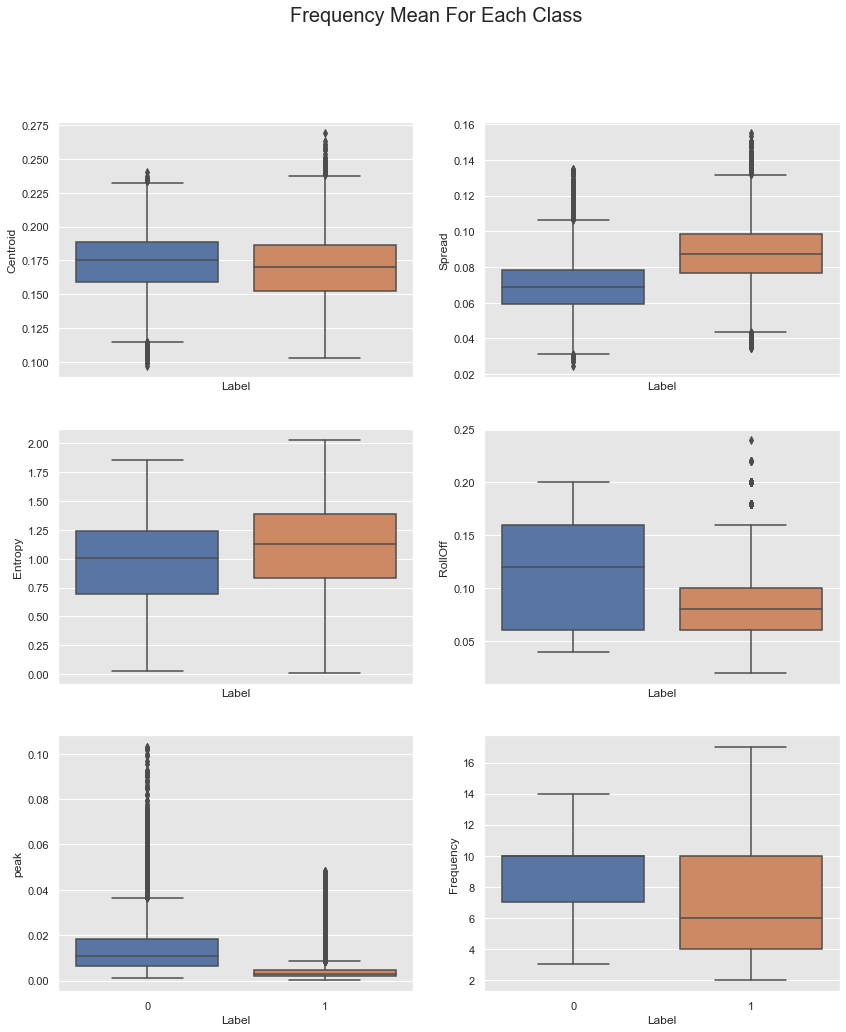

In [43]:
# df_Ffft['Label'] = df_Ffft['Label'].map({ 1 : 'Open', 0 : 'Closed'})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
f, axes = plt.subplots(3, 2, figsize=(14, 16), sharex=True)
f.suptitle('Frequency Mean For Each Class', fontsize=20)

sns.boxplot(x="Label", y='Centroid', data=df_Ffft,ax=axes[0, 0])
sns.boxplot(x="Label", y='Spread', data=df_Ffft, ax=axes[0, 1])
sns.boxplot(x="Label", y='Entropy', data=df_Ffft, ax=axes[1, 0])
sns.boxplot(x="Label", y='RollOff', data=df_Ffft, ax=axes[1, 1])
sns.boxplot(x="Label", y='peak', data=df_Ffft,  ax=axes[2, 0])
sns.boxplot(x="Label", y='Frequency', data=df_Ffft,ax=axes[2, 1])

plt.show()

# 3º Method 

#### Time-frrequency Domain Features

The plot below show a example of a wavelet decomposition applield to a random row of EEG

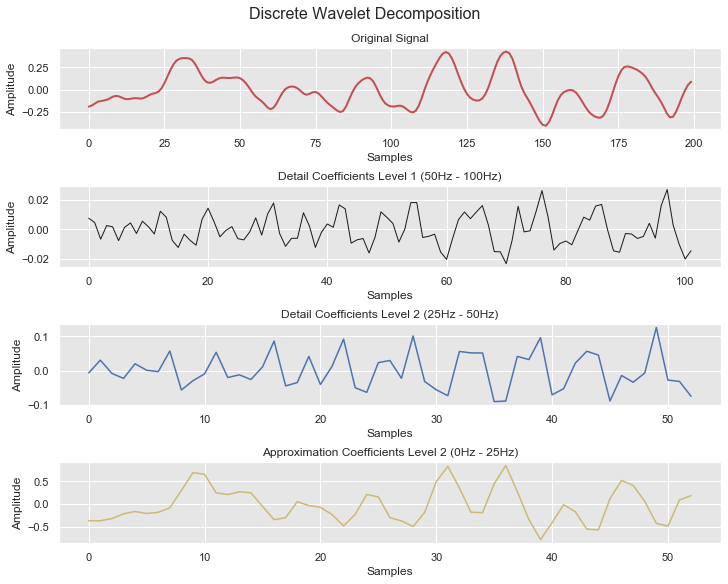

In [45]:
cA2, cD2, cD1 = pywt.wavedec(scaled_signals[9000, :], 'coif1', level=2)

fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(10,8))
fig.suptitle('Discrete Wavelet Decomposition', fontsize=16)

axs[0].plot(scaled_signals[9000, :], 'r', linewidth=2)
axs[0].set_title('Original Signal')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')


axs[1].plot(cD1, 'k', linewidth=1)
axs[1].set_title('Detail Coefficients Level 1 (50Hz - 100Hz)')
axs[1].set_xlabel('Samples')
axs[1].set_ylabel('Amplitude')


axs[2].plot(cD2)
axs[2].set_xlabel('Samples')
axs[2].set_title('Detail Coefficients Level 2 (25Hz - 50Hz)')
axs[2].set_ylabel('Amplitude')

axs[3].plot(cA2, 'y')
axs[3].set_xlabel('Samples')
axs[3].set_title('Approximation Coefficients Level 2 (0Hz - 25Hz)')
axs[3].set_ylabel('Amplitude')

plt.show()

<i> Here we apply DWT to do a multilevel Discrete Wavelet Transforms, and we only make use of the last level, where it is found the brain low frequencies </i>

In [46]:
%%time
# Wavelet
aux_wavelet =[]
lvl = 0

for row in scaled_signals:
    
#     
    dec_wave_lvs = pywt.wavedec(row, 'coif1', level=2) 
    dec_wave = dec_wave_lvs[0]
#     dec_wave = np.array(dec_wave).reshape((np.size(dec_wave)))
    aux_wavelet.append(dec_wave)
    
##---     
wavelet = np.array(aux_wavelet)
np.shape(wavelet)

Wall time: 1.74 s


<i> Before and after the wavelet transform</i>

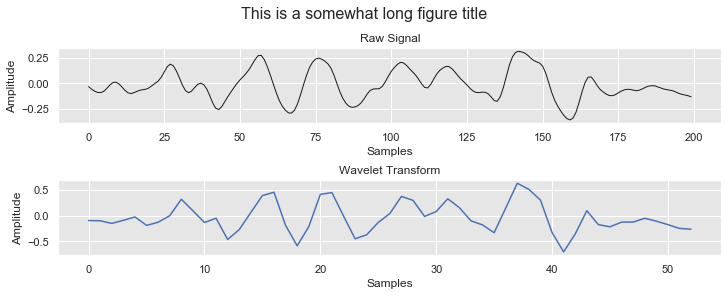

In [47]:
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10,4))
axs[0].plot(scaled_signals[15000, :], 'k', linewidth=1)
axs[0].set_title('Raw Signal')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')
fig.suptitle('This is a somewhat long figure title', fontsize=16)

axs[1].plot(wavelet[15000])
axs[1].set_xlabel('Samples')
axs[1].set_title('Wavelet Transform')
axs[1].set_ylabel('Amplitude')

plt.show()

<i>The only difference we can notice is the effect of the small amount of samples present on the wavelet decomposition. Few changes occur after DWT, because the signal, previously, passed through some filters present in the software responsible for recording the EEG signal.
Because of that, there were no High Frenquecy component in the signal to be removed by the wavelet transform.</i>

***
- Part I - *Inicialy, we are going to define some functions that will be necessary to extract the features*

<i>Features used :</i>

<blockquote> 
    
- Entropy
    
- Median 
- Mean
- Standard deviation 
- Variance
- Arithmetic mean
- Percentile of the data ignoring nan values
- Kurtosis
- CPT5
- Normalized entropy
- SRAV
- Mean absolute

In [48]:
def CPT5(x):
    den = len(x)*np.exp(np.std(x))
    return sum(np.exp(x))/den

def SSC(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1 
    xn_i1 = x[0:len(x)-2]  # xn-1
    ans = np.heaviside((xn-xn_i1)*(xn-xn_i2),0)
    return sum(ans[1:]) 

def wave_length(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1 
    return sum(abs(xn_i2-xn))
    
def norm_entropy(x):
    tresh = 2
    return sum(np.power(abs(x),tresh))

def SRAV(x):    
    SRA = sum(np.sqrt(abs(x)))
    return np.power(SRA/len(x),2)

def mean_abs(x):
    return sum(abs(x))/len(x)

def calculate_entropy(list_values):
#     counter_values = Counter(list_values).most_common()
#     probabilities = [elem[1]/len(list_values) for elem in counter_values]
#     entropy=scipy.stats.entropy(probabilities)
    entropy_ = spectral_entropy(list_values, 100, method='welch', normalize=True)    
    return entropy_

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    kts = kurtosis(list_values)
    cpt5 = CPT5(list_values)
    ssc = SSC(list_values)
    n_etp = norm_entropy(list_values)
    mn_abs = SRAV(list_values)
    
    return [n5, n25, n75, n95, median, mean, std, var, rms, kts, cpt5, ssc, n_etp, mn_abs]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

- Part II - <i> Here it is the place where the features are extracted </i>

In [49]:
 # Wavelet
aux_feature =[]


for wave in wavelet:
    
#     
    feature = get_features(wave) 
    aux_feature.append(feature)
    
##---     
features = np.array(aux_feature)
np.shape(features)

(18846, 17)

<i> Putting the features into a data frame</i>

In [50]:
min_max_scaler = preprocessing.MinMaxScaler()
features_scaled = min_max_scaler.fit_transform(features)

features_names = ['Entropy', 'No Zero Crossings', 'No Mean Crossings', 'N5', 'N25', 'N75', 'N95',
                  'Median', 'Mean', 'Std', 'Var', 'Rms',  'Kts', 'CPT5', 'SSC', 'Norme Entropy', 'Absolute Mean']

df_features = pd.DataFrame(features_scaled,columns=features_names)
df_features.insert(17, "Label", 0) 
df_features["Label"] = label
df_features.head()

,Entropy,No Zero Crossings,No Mean Crossings,N5,N25,N75,N95,Median,Mean,Std,Var,Rms,Kts,CPT5,SSC,Norme Entropy,Absolute Mean,Label
0,0.675907,0.631579,0.50,0.628298,0.565294,0.654836,0.540762,0.530755,0.664011,0.565292,0.392395,0.567441,0.051155,0.478856,0.409091,0.391309,0.541575,0
1,0.685193,0.631579,0.60,0.606522,0.506801,0.460215,0.568826,0.625396,0.646563,0.559636,0.386242,0.581090,0.054351,0.472627,0.409091,0.384527,0.587410,0
2,0.707027,0.578947,0.55,0.652938,0.503379,0.350997,0.438160,0.405244,0.472547,0.507743,0.331888,0.496676,0.092986,0.401949,0.454545,0.329822,0.466940,0
3,0.694965,0.368421,0.45,0.653756,0.581311,0.384073,0.488569,0.483572,0.510048,0.516467,0.340761,0.502821,0.081003,0.416023,0.409091,0.337876,0.469253,0
4,0.680467,0.526316,0.40,0.652480,0.583717,0.482941,0.470815,0.628414,0.675729,0.512293,0.336502,0.507574,0.075827,0.522218,0.454545,0.336435,0.483086,0


#  Feature Selection
***
Feature selection is one of the first and important steps while performing any machine learning task. A feature in case of a dataset simply means a column. When we get any dataset, not necessarily every column (feature) is going to have an impact on the output variable. If we add these irrelevant features in the model, it will just make the model worst (Garbage In Garbage Out). This gives rise to the need of doing feature selection.

- **Part I - Inicialy, we are computing the corelation among the feature and target in order to choose the bests ones**

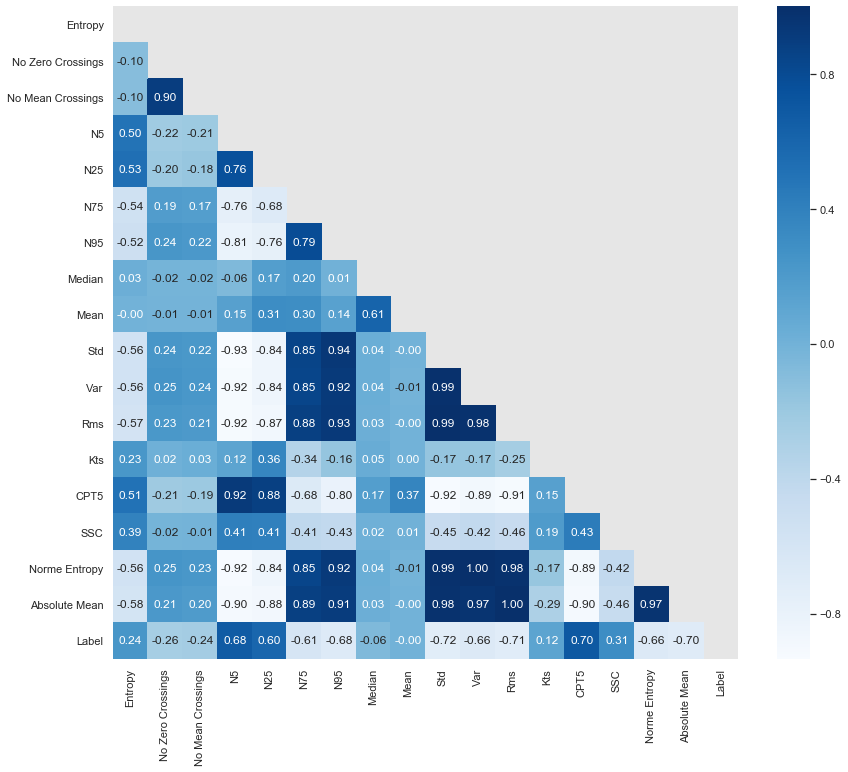

In [51]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(12, 9))
# sns.heatmap(df_features.corr(), annot = True, fmt = '.2f', cmap='Blues')

# plt.title('Correlação entre variáveis do dataset de EEG')
# 

# sns.set(style="white")
# Compute the correlation matrix
corr2 = df_features.corr()

# Generate a mask for the upper triangle
mask2 = np.zeros_like(corr2, dtype=np.bool)
mask2[np.triu_indices_from(mask2)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 12))

# Generate a custom diverging colormap
cmap = 'Blues'
sns.heatmap(corr2, mask=mask2, annot = True, fmt = '.2f', cmap='Blues')
# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Pearson Coefficient of Correlation is the first method used to select the features in which have an absolute corelation with the target higher than 0.5

In [52]:
#Correlation with output variable
cor = df_features.corr().round(2) 
cor_target = abs(cor["Label"])
#Selecting highly correlated features
relevant_features_1 = cor_target[cor_target>0.5]
relevant_features_1

N5               0.68
N25              0.60
N75              0.61
N95              0.68
Std              0.72
Var              0.66
Rms              0.71
CPT5             0.70
Norme Entropy    0.66
Absolute Mean    0.70
Label            1.00
Name: Label, dtype: float64

In [53]:
X_ = df_features.drop(['Label'], axis=1).copy()
y_ = df_features['Label'].copy()

filtered_list_1 = [string for string in features_names if string not in relevant_features_1]
df_ft_model_1 = X_.drop(columns=filtered_list_1).copy()

- **Part II - Here, we are using other methode to descovery the best features**

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, random_state=42)
# Treinando modelo
model  = RandomForestClassifier()
model.fit(X_train, y_train)
# Mostrando importância de cada feature
model.feature_importances_

array([0.05158498, 0.02611114, 0.02194881, 0.02224806, 0.01989954,
       0.01799583, 0.02270251, 0.02091461, 0.01419707, 0.1987887 ,
       0.08922998, 0.08159362, 0.02487817, 0.01938067, 0.02460512,
       0.32173495, 0.02218624])

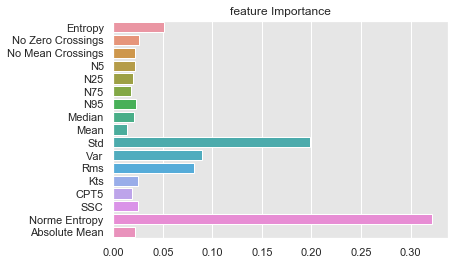

In [55]:
importances = pd.Series(data=model.feature_importances_, index=features_names)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('feature Importance')
plt.show()

In [56]:
import_target = importances
#Selecting highly correlated features
relevant_features_2 = import_target[import_target>0.04]
relevant_features_2

Entropy          0.051585
Std              0.198789
Var              0.089230
Rms              0.081594
Norme Entropy    0.321735
dtype: float64

In [57]:
filtered_list_2 = [string for string in features_names if string not in relevant_features_2]
df_ft_model_2 = X_.drop(columns=filtered_list_2).copy()

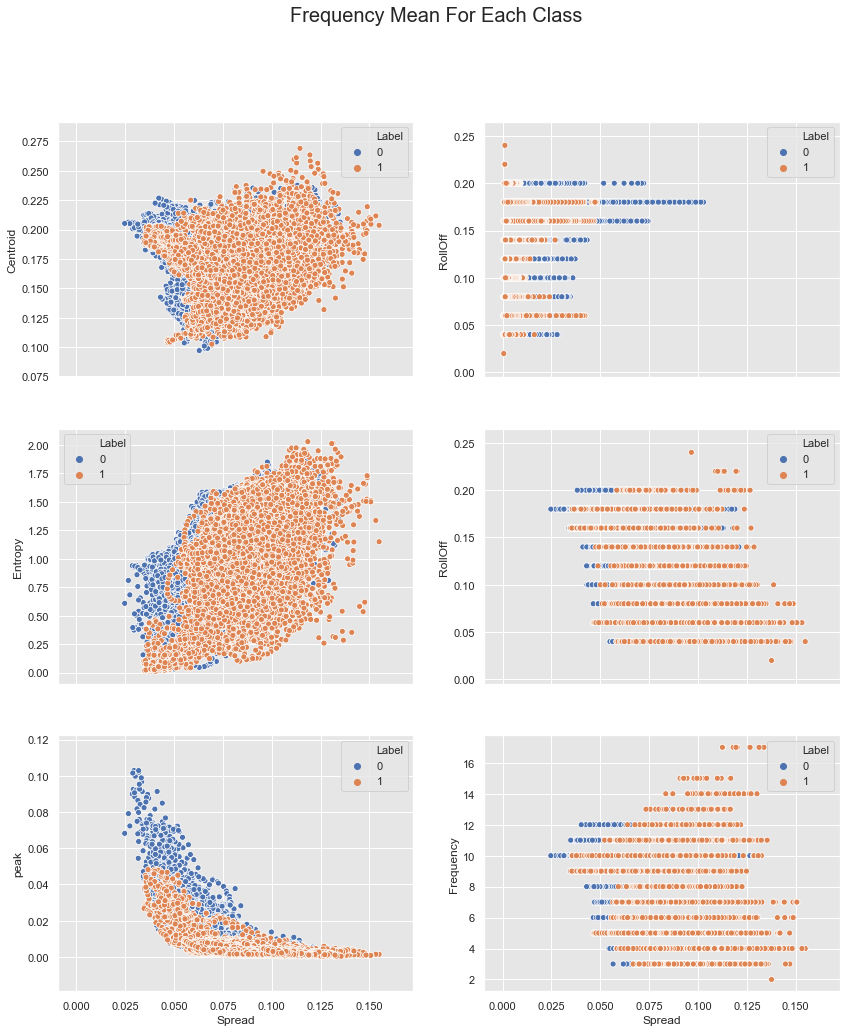

In [58]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
f, axes = plt.subplots(3, 2, figsize=(14, 16), sharex=True)
f.suptitle('Frequency Mean For Each Class', fontsize=20)

sns.scatterplot(x="Spread", y='Centroid', hue="Label", data=df_Ffft,ax=axes[0, 0])
sns.scatterplot(x="peak", y='RollOff', hue="Label", data=df_Ffft, ax=axes[0, 1])
sns.scatterplot(x="Spread", y='Entropy', hue="Label", data=df_Ffft, ax=axes[1, 0])
sns.scatterplot(x="Spread", y='RollOff', hue="Label", data=df_Ffft, ax=axes[1, 1])
sns.scatterplot(x="Spread", y='peak', hue="Label", data=df_Ffft,  ax=axes[2, 0])
sns.scatterplot(x="Spread", y='Frequency', hue="Label", data=df_Ffft,ax=axes[2, 1])

plt.show()



#  Classification
***
In machine learning and statistics, classification is a supervised learning approach in which the computer program learns from the data input given to it and then uses this learning to classify new observation.


<i>Now We are gonig to use some Machine Learning Model using the differents sets of features tha we have been created :</i>

<img src="class.png"  style="width: 25%;float:left; margin-right:60px"/>

- **Part I - Using all features**

#### <blockquote> k-Nearest Neighbor

In [59]:
%%time
knn = KNeighborsClassifier(n_neighbors=20)
KNN_scores_Method1 = cross_val_score(knn, ffts, df_Ffft_y, cv=20, scoring='accuracy')
KNN_scores_Method2 = cross_val_score(knn, df_Ffft_x, df_Ffft_y, cv=20, scoring='accuracy')
KNN_scores_Method3 = cross_val_score(knn, df_ft_model_1, df_Ffft_y, cv=20, scoring='accuracy')
KNN_scores_Method4 = cross_val_score(knn, df_ft_model_2, df_Ffft_y, cv=20, scoring='accuracy')

print('Accuracy for KNN Classifier using FFT row           : ', KNN_scores_Method1.mean())
print('Accuracy for KNN Classifier using FFT features      : ', KNN_scores_Method2.mean())
print('Accuracy for KNN Classifier using wavelet features 1: ', KNN_scores_Method3.mean())
print('Accuracy for KNN Classifier using wavelet features 2: ', KNN_scores_Method4.mean())

Accuracy for KNN Classifier using FFT row           :  0.8333261362409587
Accuracy for KNN Classifier using FFT features      :  0.7219366251034581
Accuracy for KNN Classifier using wavelet features 1:  0.8764208634711578
Accuracy for KNN Classifier using wavelet features 2:  0.8857067994530208
Wall time: 23.2 s


#### <blockquote> Naive Bayes

In [60]:
%%time
gnb = GaussianNB()


gnb_scores_Method1 = cross_val_score(gnb, ffts, df_Ffft_y, cv=20, scoring='accuracy')
gnb_scores_Method2 = cross_val_score(gnb, df_Ffft_x, df_Ffft_y, cv=20, scoring='accuracy')
gnb_scores_Method3 = cross_val_score(gnb, df_ft_model_1, df_Ffft_y, cv=20, scoring='accuracy')
gnb_scores_Method4 = cross_val_score(gnb, df_ft_model_2, df_Ffft_y, cv=20, scoring='accuracy')


print('Accuracy for Naive Bayes Classifier using FFT row           : ', gnb_scores_Method1.mean())
print('Accuracy for Naive Bayes Classifier using FFT features      : ', gnb_scores_Method2.mean())
print('Accuracy for Naive Bayes Classifier using wavelet features 1: ', gnb_scores_Method3.mean())
print('Accuracy for Naive Bayes Classifier using wavelet features 2: ', gnb_scores_Method4.mean())

Accuracy for Naive Bayes Classifier using FFT row           :  0.8159217676058873
Accuracy for Naive Bayes Classifier using FFT features      :  0.7347866961747453
Accuracy for Naive Bayes Classifier using wavelet features 1:  0.8593270943538812
Accuracy for Naive Bayes Classifier using wavelet features 2:  0.8496697209327431
Wall time: 1.66 s


#### <blockquote> Multilayer Perceptron

In [61]:
%%time
MLP_clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(50, 4, 2), random_state=1, max_iter=150)


MLP_scores_Method1 = cross_val_score(MLP_clf, ffts, df_Ffft_y, cv=20, scoring='accuracy')
MLP_scores_Method2 = cross_val_score(MLP_clf, df_Ffft_x, df_Ffft_y, cv=20, scoring='accuracy')
MLP_scores_Method3 = cross_val_score(MLP_clf, df_ft_model_1, df_Ffft_y, cv=20, scoring='accuracy')
MLP_scores_Method4 = cross_val_score(MLP_clf, df_ft_model_2, df_Ffft_y, cv=20, scoring='accuracy')


print('Accuracy for Multilayer Perceptron Classifier using FFT row           : ', MLP_scores_Method1.mean())
print('Accuracy for Multilayer Perceptron Classifier using FFT features      : ', MLP_scores_Method2.mean())
print('Accuracy for Multilayer Perceptron Classifier using wavelet features 1: ', MLP_scores_Method3.mean())
print('Accuracy for Multilayer Perceptron Classifier using wavelet features 2: ', MLP_scores_Method4.mean())

Accuracy for Multilayer Perceptron Classifier using FFT row           :  0.5201634414696464
Accuracy for Multilayer Perceptron Classifier using FFT features      :  0.7458458157904208
Accuracy for Multilayer Perceptron Classifier using wavelet features 1:  0.5201634414696464
Accuracy for Multilayer Perceptron Classifier using wavelet features 2:  0.5201634414696464
Wall time: 6min 12s


#### <blockquote> Linear Discriminant Analysis

In [62]:
lda = LDA()
scores = cross_val_score(lda, X_, y_, cv=20, scoring='accuracy')

lda_scores_Method1 = cross_val_score(lda, ffts, df_Ffft_y, cv=20, scoring='accuracy')
lda_scores_Method2 = cross_val_score(lda, df_Ffft_x, df_Ffft_y, cv=20, scoring='accuracy')
lda_scores_Method3 = cross_val_score(lda, df_ft_model_1, df_Ffft_y, cv=20, scoring='accuracy')
lda_scores_Method4 = cross_val_score(lda, df_ft_model_2, df_Ffft_y, cv=20, scoring='accuracy')


print('Accuracy for LDA Classifier using FFT row           : ', lda_scores_Method1.mean())
print('Accuracy for LDA Classifier using FFT features      : ', lda_scores_Method2.mean())
print('Accuracy for LDA Classifier using wavelet features 1: ', lda_scores_Method3.mean())
print('Accuracy for LDA Classifier using wavelet features 2: ', lda_scores_Method4.mean())

Accuracy for LDA Classifier using FFT row           :  0.8169240751736299
Accuracy for LDA Classifier using FFT features      :  0.7635840620389363
Accuracy for LDA Classifier using wavelet features 1:  0.8816202004390226
Accuracy for LDA Classifier using wavelet features 2:  0.889737733455684


#### <blockquote> Suport Vector Machine

In [63]:
%%time
SVM_clf = svm.SVC(kernel='linear', C = 1.0)
scores3 = cross_val_score(SVM_clf, df_features, label, cv=15, scoring='accuracy')

SVM_scores_Method1 = cross_val_score(SVM_clf, ffts, df_Ffft_y, cv=10, scoring='accuracy')
SVM_scores_Method2 = cross_val_score(SVM_clf, df_Ffft_x, df_Ffft_y, cv=10, scoring='accuracy')
SVM_scores_Method3 = cross_val_score(SVM_clf, df_ft_model_1, df_Ffft_y, cv=10, scoring='accuracy')
SVM_scores_Method4 = cross_val_score(SVM_clf, df_ft_model_2, df_Ffft_y, cv=10, scoring='accuracy')


print('Accuracy for LDA Classifier using FFT row           : ', SVM_scores_Method1.mean())
print('Accuracy for LDA Classifier using FFT features      : ', SVM_scores_Method2.mean())
print('Accuracy for LDA Classifier using wavelet features 1: ', SVM_scores_Method3.mean())
print('Accuracy for LDA Classifier using wavelet features 2: ', SVM_scores_Method4.mean())

Accuracy for LDA Classifier using FFT row           :  0.651329834538999
Accuracy for LDA Classifier using FFT features      :  0.7235808381346067
Accuracy for LDA Classifier using wavelet features 1:  0.8799203202500039
Accuracy for LDA Classifier using wavelet features 2:  0.8906378545231034
Wall time: 7min 21s


In [64]:
KNN = [KNN_scores_Method1.mean()* 100, KNN_scores_Method2.mean()* 100, KNN_scores_Method3.mean()* 100, KNN_scores_Method4.mean()* 100] 
NB = [gnb_scores_Method1.mean()* 100, gnb_scores_Method2.mean()* 100, gnb_scores_Method3.mean()* 100, gnb_scores_Method4.mean()* 100] 
MLP = [MLP_scores_Method1.mean()* 100, MLP_scores_Method2.mean()* 100, MLP_scores_Method3.mean()* 100, MLP_scores_Method4.mean()* 100] 
LDA = [lda_scores_Method1.mean()* 100, lda_scores_Method2.mean()* 100, lda_scores_Method3.mean()* 100, lda_scores_Method4.mean()* 100] 
SVM = [SVM_scores_Method1.mean()* 100, SVM_scores_Method2.mean()* 100, SVM_scores_Method3.mean()* 100, SVM_scores_Method4.mean()* 100] 

table_data = [KNN, NB, MLP, LDA, SVM]

collabel=['k-Nearest Neighbor', "Naive Bayes", "Multilayer Perceptron","Linear Discriminant Analysis", 
          "Suport Vector Machine"]

df = pd.DataFrame(table_data,index=collabel,columns=['FFT Row', 'FFT Features', 'DWT Features I', 'DWT Features II'])
df.round({"FFT Row":2, "FFT Features":2, "DWT Features I":2, "DWT Features II":2}) 

,FFT Row,FFT Features,DWT Features I,DWT Features II
k-Nearest Neighbor,83.33,72.19,87.64,88.57
Naive Bayes,81.59,73.48,85.93,84.97
Multilayer Perceptron,52.02,74.58,52.02,52.02
Linear Discriminant Analysis,81.69,76.36,88.16,88.97
Suport Vector Machine,65.13,72.36,87.99,89.06


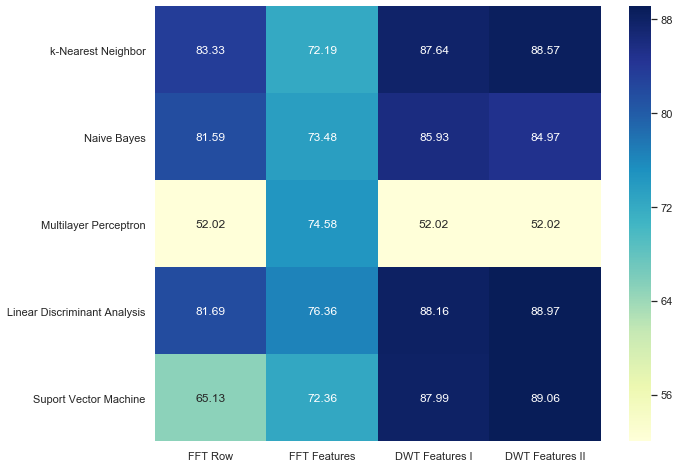

In [65]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df, annot=True, fmt = '.2f',cmap="YlGnBu")
plt.show()